In [4]:
import matplotlib.pyplot as plt
import os

from dask.distributed import Client

from ase.cluster import Decahedron
from abtem import show_atoms, FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector

os.environ["MKL_NUM_THREADS"] = "1"

In [5]:
client = Client()

C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 64882 instead
  warnings.warn(


<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>

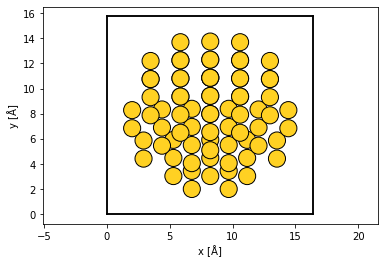

In [6]:
p = 2
q = 2
r = 1

atoms = Decahedron('Au', p, q, r, latticeconstant=None)
atoms.rotate(30, 'x', center='cop')

atoms.center(vacuum=2)

show_atoms(atoms)

In [21]:
frozen_phonons = FrozenPhonons(atoms, 2, {'Au': .1})

potential = Potential(frozen_phonons, 
                      sampling=.05, 
                      device='cpu', 
                      projection='infinite', 
                      slice_thickness=.5)

probe = SMatrix(energy=100e3, semiangle_cutoff=20, device='cpu', chunks=50)
scan = GridScan()
detectors = AnnularDetector(80, 120)

probe.match_grid(potential)

probe.wave_vectors

#probe.multislice(potential)

#probe.wave_vectors

#probe.build().array.visualize()
#
#measurement = probe.scan(scan, detectors, potential, chunks=100)

dask.array<array, shape=(241, 2), dtype=float32, chunksize=(50, 2), chunktype=numpy.ndarray>

In [7]:
%%time
measurement.compute()

Wall time: 35.6 s


(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x20ab5aa2e80>)

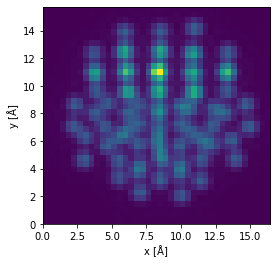

In [8]:
measurement.show()

In [9]:
measurement.array

array([[1.14269169e-04, 1.32483023e-04, 1.39306139e-04, ...,
        1.13393326e-04, 1.30536879e-04, 1.29304768e-04],
       [1.05915511e-04, 1.23229256e-04, 1.12597023e-04, ...,
        1.35508162e-04, 1.28113403e-04, 1.01133963e-04],
       [1.27414722e-04, 1.08437191e-04, 1.02958875e-04, ...,
        1.51340617e-04, 1.17806376e-04, 1.02775994e-04],
       ...,
       [1.33575086e-04, 1.40269767e-04, 1.22739992e-04, ...,
        1.18031174e-04, 1.62985656e-04, 1.33274589e-04],
       [1.14291841e-04, 1.15133960e-04, 1.05123923e-04, ...,
        1.53874353e-04, 1.34919290e-04, 9.06600326e-05],
       [1.30889151e-04, 1.22375466e-04, 1.14381684e-04, ...,
        1.55844609e-04, 1.14509072e-04, 1.05902291e-04]], dtype=float32)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x20ab5ce3c10>)

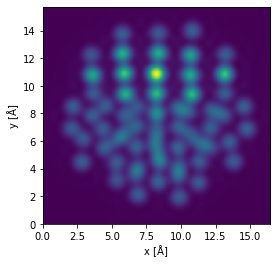

In [18]:
measurement.interpolate(.1).show()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x256af179640>)

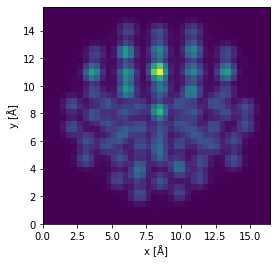

In [15]:
measurement.show()